In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice

results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

DATA_STORE = Path(results_path / 'data.h5')
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [3]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()


In [4]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2022':], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

trade_prices = get_trade_prices(tickers)

In [5]:
trade_prices

ticker                     000020.KS  000040.KS     000050.KS     000070.KS  \
date                                                                          
2022-01-07 00:00:00+00:00    14500.0      912.0  14088.068359  91070.809565   
2022-01-14 00:00:00+00:00    13700.0      869.0  14483.522461  88979.407039   
2022-01-21 00:00:00+00:00    12800.0      829.0  14335.227718  85367.000967   
2022-01-28 00:00:00+00:00    12000.0      766.0  13840.909441  83085.474654   
2022-02-04 00:00:00+00:00    12550.0      810.0  14285.795628  85842.317354   
...                              ...        ...           ...           ...   
2023-07-21 00:00:00+00:00    10300.0      510.0   9770.000000  71500.000000   
2023-07-28 00:00:00+00:00     9810.0      490.0   9520.000000  69400.000000   
2023-08-04 00:00:00+00:00    10520.0      522.0   9450.000000  70000.000000   
2023-08-11 00:00:00+00:00    10580.0      517.0   9450.000000  70900.000000   
2023-08-18 00:00:00+00:00     9660.0      543.0   9180.000000  69000.000000   

ticker                     000075.KS  000087.KS     000100.KS  000105.KS  \
date                                                                       
2022-01-07 00:00:00+00:00    67500.0    19250.0  57215.039062    60300.0   
2022-01-14 00:00:00+00:00    68800.0    19000.0  57025.898251    58100.0   
2022-01-21 00:00:00+00:00    67100.0    18800.0  55039.920402    57000.0   
2022-01-28 00:00:00+00:00    67400.0    18100.0  54377.933405    55500.0   
2022-02-04 00:00:00+00:00    66500.0    19200.0  54472.500732    56500.0   
...                              ...        ...           ...        ...   
2023-07-21 00:00:00+00:00    53900.0    16000.0  67700.000000    57900.0   
2023-07-28 00:00:00+00:00    51100.0    15500.0  70800.000000    58000.0   
2023-08-04 00:00:00+00:00    52500.0    15480.0  73500.000000    61400.0   
2023-08-11 00:00:00+00:00    52500.0    15790.0  75400.000000    62800.0   
2023-08-18 00:00:00+00:00    51300.0    15220.0  72500.000000    60200.0   

ticker                         000120.KS  000140.KS  ...  450140.KS  \
date                                                 ...              
2022-01-07 00:00:00+00:00  125832.808191    12450.0  ...        NaN   
2022-01-14 00:00:00+00:00  123843.358584    12300.0  ...        NaN   
2022-01-21 00:00:00+00:00  124340.723463    11900.0  ...        NaN   
2022-01-28 00:00:00+00:00  115388.189863    11500.0  ...        NaN   
2022-02-04 00:00:00+00:00  120361.820312    12350.0  ...        NaN   
...                                  ...        ...  ...        ...   
2023-07-21 00:00:00+00:00   75200.000000     9090.0  ...     3875.0   
2023-07-28 00:00:00+00:00   73300.000000     8830.0  ...     3750.0   
2023-08-04 00:00:00+00:00   81600.000000     9040.0  ...     3760.0   
2023-08-11 00:00:00+00:00   83100.000000     9000.0  ...     3865.0   
2023-08-18 00:00:00+00:00   77600.000000     8670.0  ...     3740.0   

ticker                     45014K.KS  451800.KS  452260.KS  453340.KS  \
date                                                                    
2022-01-07 00:00:00+00:00        NaN        NaN        NaN        NaN   
2022-01-14 00:00:00+00:00        NaN        NaN        NaN        NaN   
2022-01-21 00:00:00+00:00        NaN        NaN        NaN        NaN   
2022-01-28 00:00:00+00:00        NaN        NaN        NaN        NaN   
2022-02-04 00:00:00+00:00        NaN        NaN        NaN        NaN   
...                              ...        ...        ...        ...   
2023-07-21 00:00:00+00:00     7800.0     5230.0     1333.0    11500.0   
2023-07-28 00:00:00+00:00     7250.0     5260.0     1271.0    11180.0   
2023-08-04 00:00:00+00:00     7150.0     5220.0     1279.0    12000.0   
2023-08-11 00:00:00+00:00     7400.0     5200.0     1362.0    12360.0   
2023-08-18 00:00:00+00:00     7400.0     5100.0     1365.0    11900.0   

ticker                     456040.KS  460850.KS  460860.KS    900140.KS  \
date                              

In [6]:
factor = pd.DataFrame(factor)

In [7]:
factor.loc['2022-01-01 00:00:00+00:00':, :]

0
date                      ticker             
2022-01-07 00:00:00+00:00 000020.KS  0.159680
                          000040.KS -0.039038
                          000050.KS -0.039652
                          000070.KS -0.060685
                          000075.KS -0.072177
...                                       ...
2023-08-18 00:00:00+00:00 456040.KS -0.008264
                          460850.KS -0.029453
                          460860.KS -0.041822
                          900140.KS -0.003046
                          950210.KS -0.029828

[66895 rows x 1 columns]

In [8]:
from alphalens.utils import get_clean_factor_and_forward_returns
factor_data = get_clean_factor_and_forward_returns(factor=factor.loc['2022-01-01 00:00:00+00:00':, :],
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=[5, 10, 21]).sort_index()
#factor_data.info()

delta_days error
delta_days error
delta_days error
Dropped 25.8% entries from factor data: 25.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.343083  0.019380 -0.052268  0.028282   9954  20.042283
2               -0.052438  0.063710 -0.009932  0.019875   9925  19.983892
3               -0.018533  0.104687  0.016362  0.025753   9909  19.951676
4                0.000138  0.150208  0.042782  0.034408   9925  19.983892
5                0.017391  0.347564  0.085164  0.054761   9952  20.038256

Returns Analysis


5D     10D     21D
Ann. alpha                                      -0.253  -0.146  -0.119
beta                                            -0.033   0.039   0.041
Mean Period Wise Return Top Quantile (bps)     -59.505 -28.764 -33.234
Mean Period Wise Return Bottom Quantile (bps)   69.221  37.226  24.012
Mean Period Wise Spread (bps)                 -128.726 -65.909 -57.015

Information Analysis


5D    10D    21D
IC Mean          -0.052 -0.053 -0.041
IC Std.           0.098  0.097  0.087
Risk-Adjusted IC -0.525 -0.545 -0.469
t-stat(IC)       -4.200 -4.360 -3.754
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.123  0.362  0.165
IC Kurtosis       0.575 -0.382  0.102

Turnover Analysis


5D    10D    21D
Quantile 1 Mean Turnover   0.607  0.661  0.717
Quantile 2 Mean Turnover   0.748  0.766  0.782
Quantile 3 Mean Turnover   0.767  0.771  0.798
Quantile 4 Mean Turnover   0.753  0.760  0.768
Quantile 5 Mean Turnover   0.602  0.656  0.750

5D    10D    21D
Mean Factor Rank Autocorrelation  0.387  0.293  0.139

<Figure size 640x480 with 0 Axes>

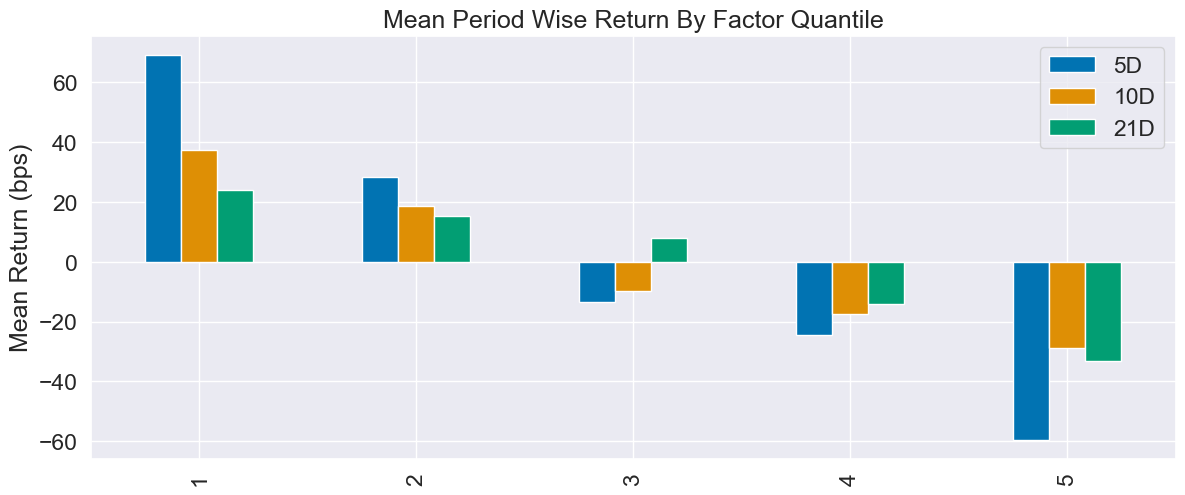

In [9]:
create_summary_tear_sheet(factor_data)

In [10]:
factor_data.to_pickle("temp_factor_data.pkl")

In [13]:
plt.rcParams['figure.dpi'] = 300

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.343083  0.019380 -0.052268  0.028282   9954  20.042283
2               -0.052438  0.063710 -0.009932  0.019875   9925  19.983892
3               -0.018533  0.104687  0.016362  0.025753   9909  19.951676
4                0.000138  0.150208  0.042782  0.034408   9925  19.983892
5                0.017391  0.347564  0.085164  0.054761   9952  20.038256

Returns Analysis


5D     10D     21D
Ann. alpha                                      -0.253  -0.146  -0.119
beta                                            -0.033   0.039   0.041
Mean Period Wise Return Top Quantile (bps)     -59.505 -28.764 -33.234
Mean Period Wise Return Bottom Quantile (bps)   69.221  37.226  24.012
Mean Period Wise Spread (bps)                 -128.726 -65.909 -57.015

<Figure size 1920x1440 with 0 Axes>

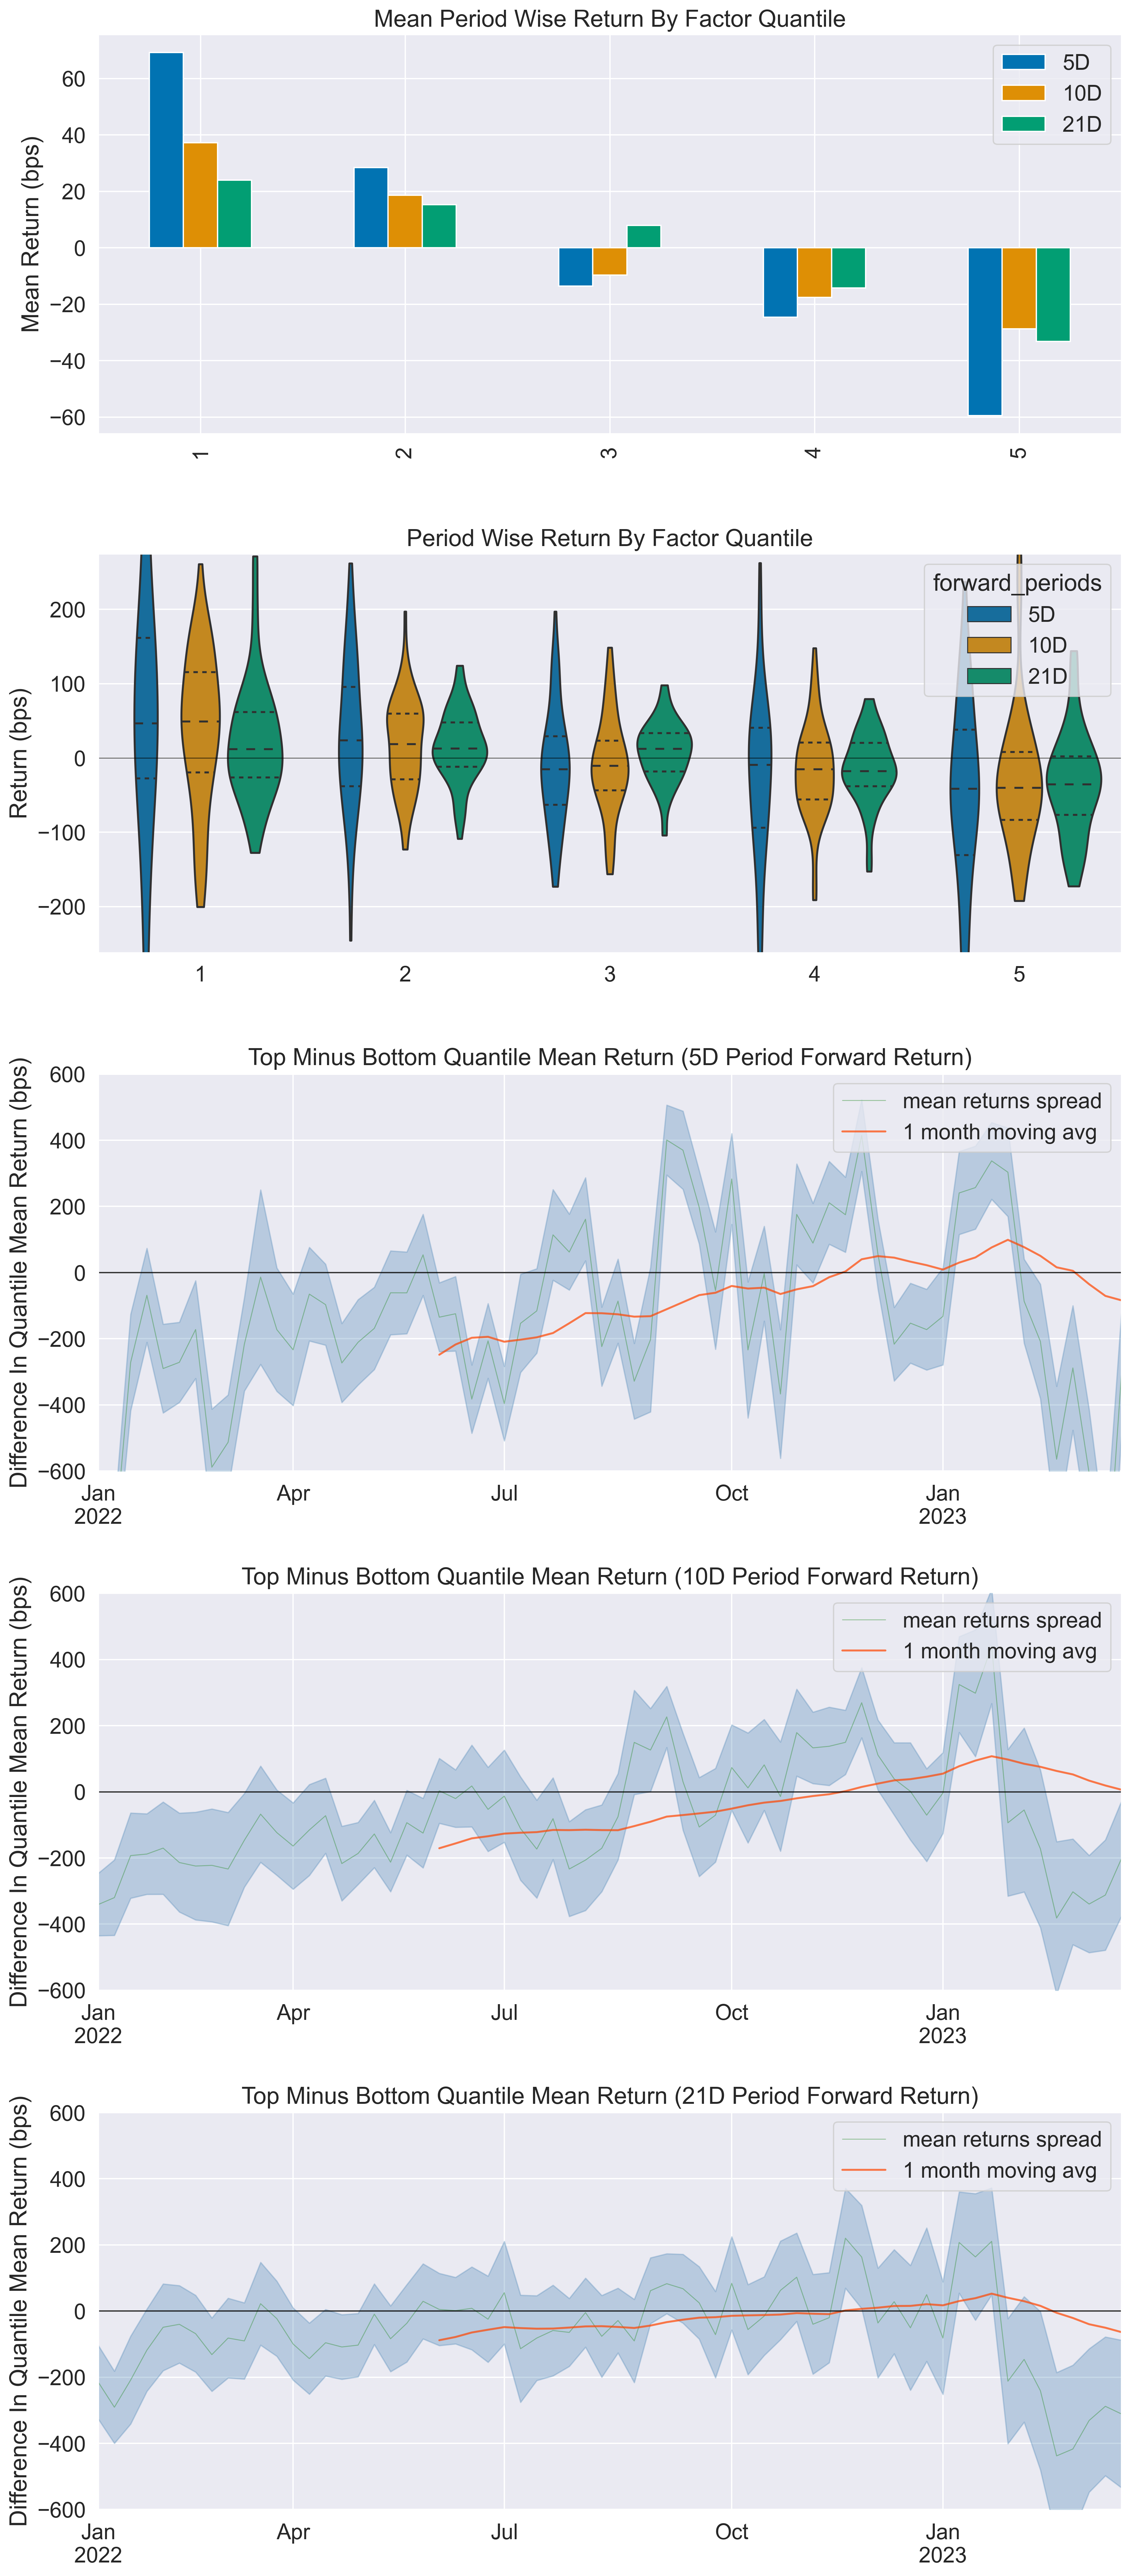

Information Analysis


5D    10D    21D
IC Mean          -0.052 -0.053 -0.041
IC Std.           0.098  0.097  0.087
Risk-Adjusted IC -0.525 -0.545 -0.469
t-stat(IC)       -4.200 -4.360 -3.754
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.123  0.362  0.165
IC Kurtosis       0.575 -0.382  0.102

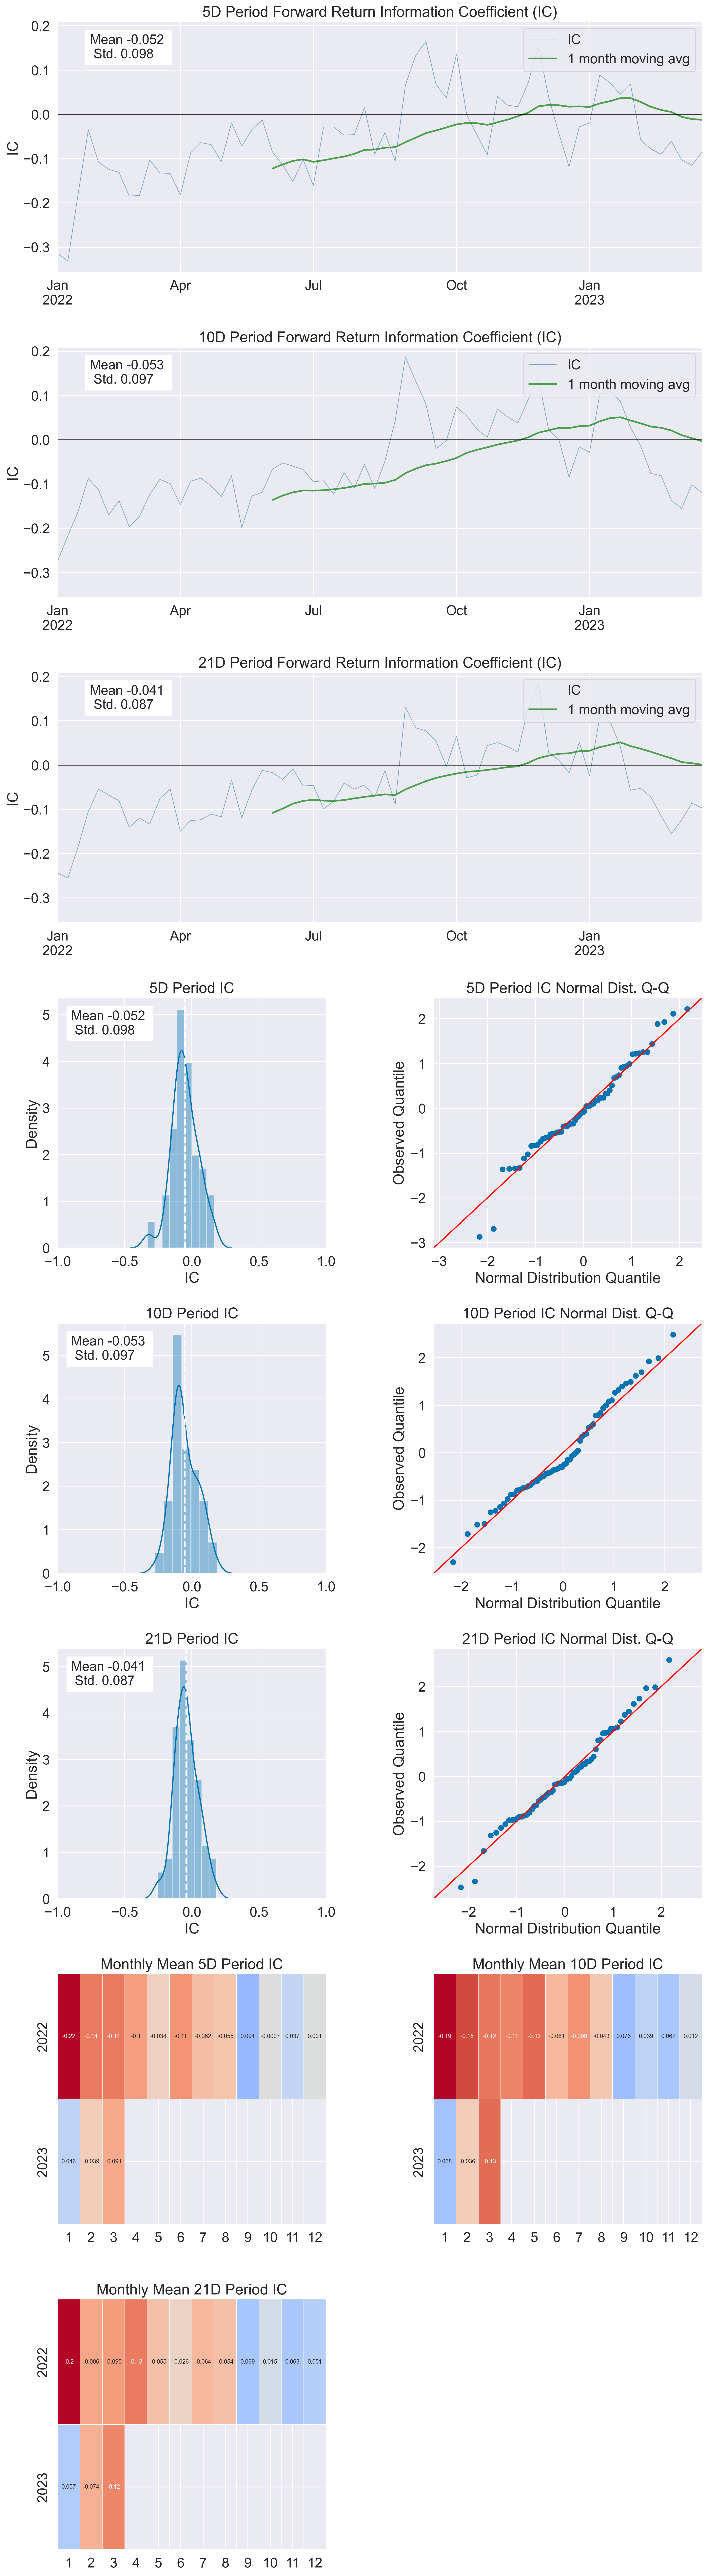

Turnover Analysis


5D    10D    21D
Quantile 1 Mean Turnover   0.607  0.661  0.717
Quantile 2 Mean Turnover   0.748  0.766  0.782
Quantile 3 Mean Turnover   0.767  0.771  0.798
Quantile 4 Mean Turnover   0.753  0.760  0.768
Quantile 5 Mean Turnover   0.602  0.656  0.750

5D    10D    21D
Mean Factor Rank Autocorrelation  0.387  0.293  0.139

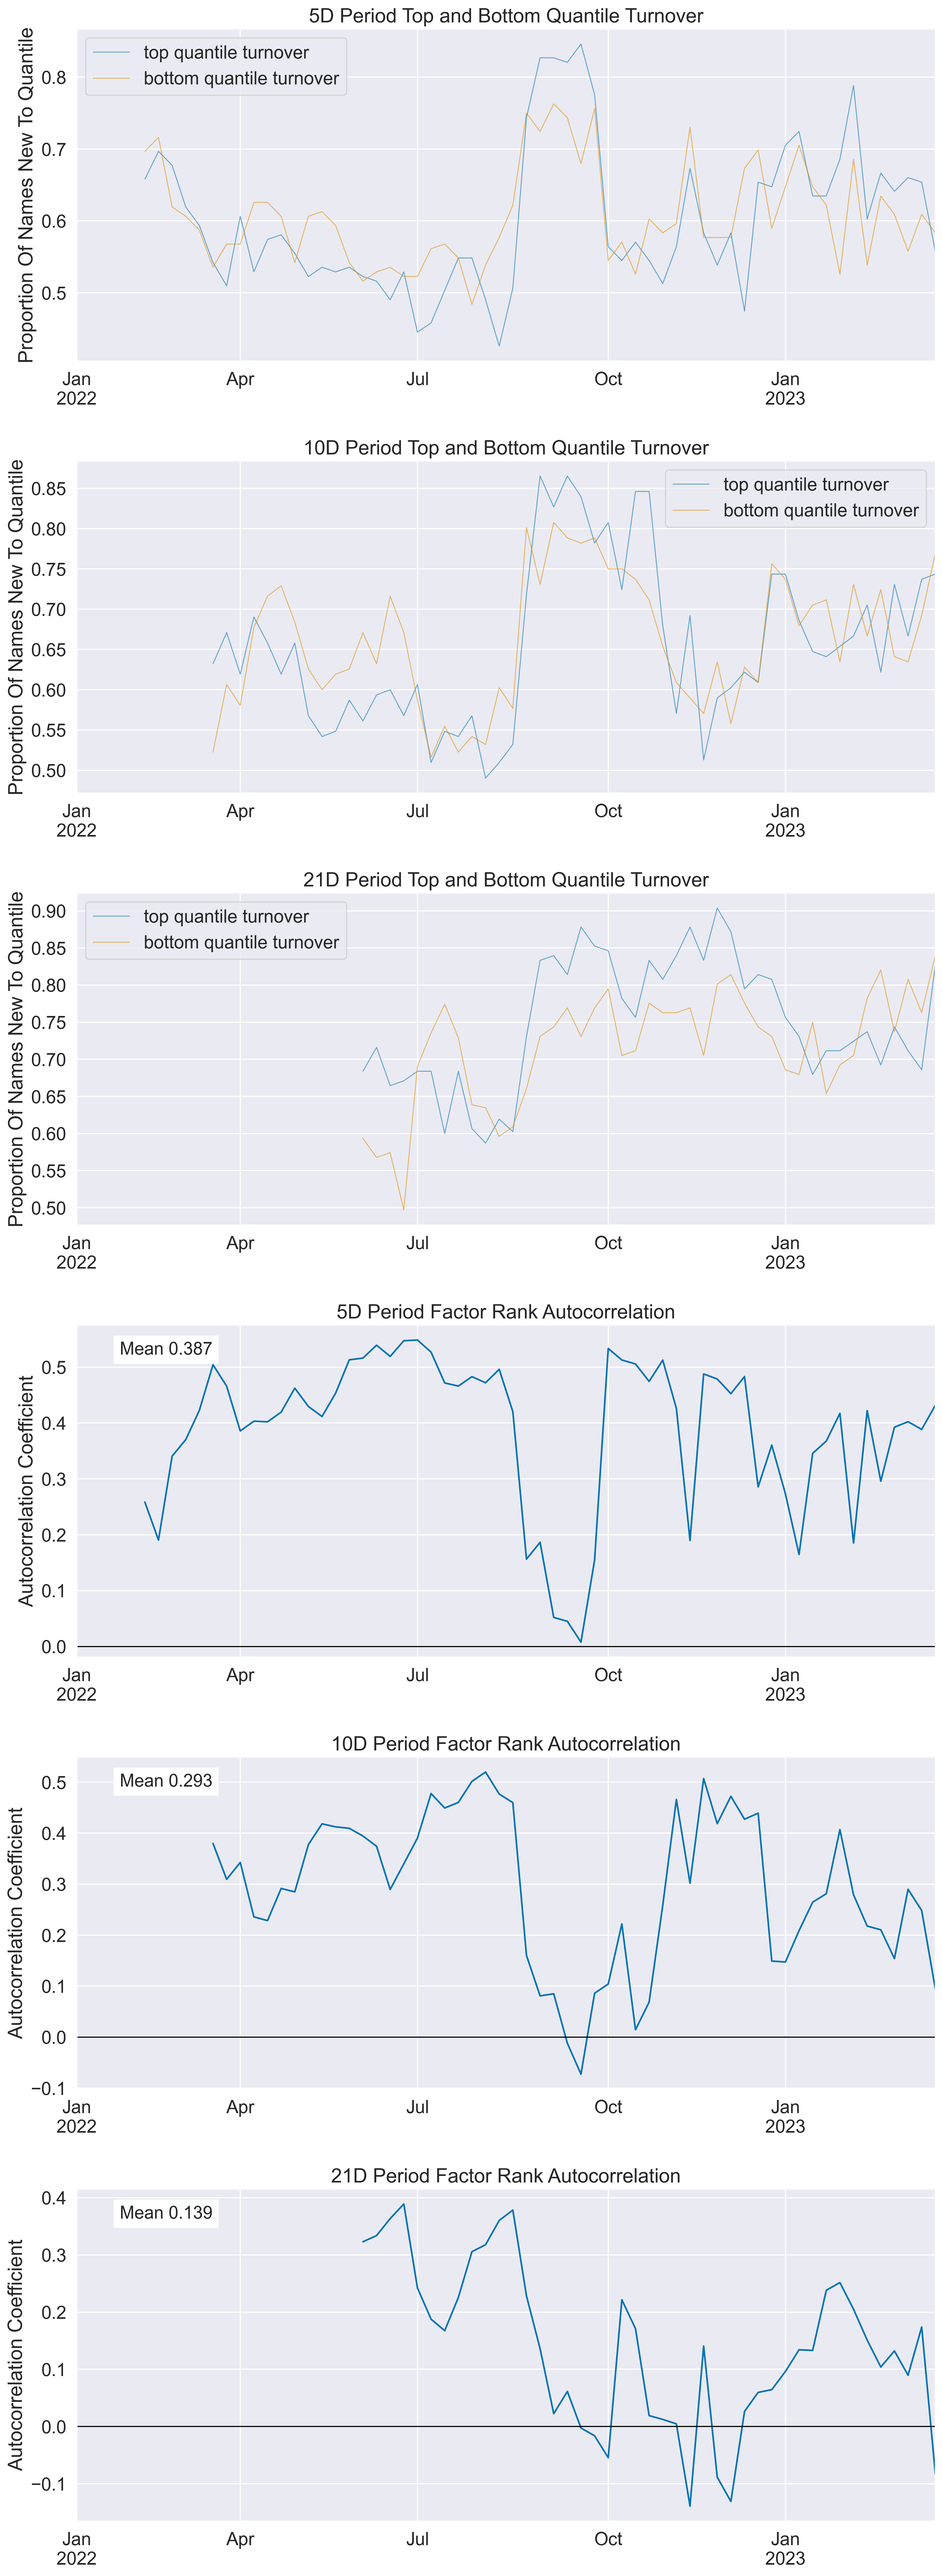

In [14]:
create_full_tear_sheet(factor_data)